In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
import pandas as pd
from dataset_sims import run_case_studies
import pickle
from helpers import evaluate_p, partition_intervals

In [3]:
DATASETS = ['swiss_nsf', 'swiss_nsf_manski', 'neuripsloo', 'neuripsgaussian', 'neuripssubjectivity', 'iclrloo', 'iclrgaussian', 'iclrsubjectivity']
DATASET_NAMES = {
    'swiss_nsf': 'Swiss NSF',
    'swiss_nsf_manski': 'Swiss NSF (Manski Bounds)',
    'neuripsloo': 'NeurIPS LOO',
    'neuripsgaussian': 'NeurIPS Gaussian',
    'neuripssubjectivity': 'NeurIPS Subjectivity',
    'iclrloo': 'ICLR LOO',
    'iclrgaussian': 'ICLR Gaussian',
    'iclrsubjectivity': 'ICLR Subjectivity'
}

In [4]:
loaded_data = run_case_studies(load_data_only=True)

===========Running Swiss NSF===========
Completed Swiss NSF in:  0.010050773620605469  seconds
===========Running Swiss NSF Manski===========
Completed Swiss NSF Manski in:  0.003124237060546875  seconds
===========Running NeurIPS LOO===========
Completed Neurips LOO in:  0.7608041763305664  seconds
===========Running NeurIPS Gaussian===========
Completed Neurips Gaussian in:  0.01714324951171875  seconds
===========Running NeurIPS Subjectivity===========
Completed Neurips Subjectivity in:  0.01937103271484375  seconds
===========Running ICLR LOO===========
Completed ICLR LOO in:  1.8730742931365967  seconds
===========Running ICLR Gaussian===========
Completed ICLR Gaussian in:  0.10212182998657227  seconds
===========Running ICLR Subjectivity===========
Completed ICLR Subjectivity in:  0.038485050201416016  seconds


In [5]:
n = {dataset: len(loaded_data[dataset]['intervals']) for dataset in DATASETS}
actual_k = {dataset: loaded_data[dataset]['k'] for dataset in DATASETS}

print('n')
print(n)
print('\nk')
print(actual_k)

n
{'swiss_nsf': 353, 'swiss_nsf_manski': 353, 'neuripsloo': 4035, 'neuripsgaussian': 4035, 'neuripssubjectivity': 4035, 'iclrloo': 11520, 'iclrgaussian': 11520, 'iclrsubjectivity': 11520}

k
{'swiss_nsf': 106, 'swiss_nsf_manski': 106, 'neuripsloo': 387, 'neuripsgaussian': 387, 'neuripssubjectivity': 387, 'iclrloo': 3703, 'iclrgaussian': 3703, 'iclrsubjectivity': 3703}


In [5]:
# compute ``width'' of each set of intervals
widths = {}
for dataset in DATASETS:
    intervals = loaded_data[dataset]['intervals']
    w = len(partition_intervals(intervals))
    widths[DATASET_NAMES[dataset]] = w

In [6]:
# dict to pandas df
print(pd.DataFrame.from_dict(widths, orient='index', columns=['width']).to_latex())

\begin{tabular}{lr}
\toprule
 & width \\
\midrule
Swiss NSF & 2 \\
Swiss NSF (Manski Bounds) & 2 \\
NeurIPS LOO & 9 \\
NeurIPS Gaussian & 19 \\
NeurIPS Subjectivity & 8 \\
ICLR LOO & 10 \\
ICLR Gaussian & 25 \\
ICLR Subjectivity & 15 \\
\bottomrule
\end{tabular}



## Overall Computation

In [9]:
results_df = pd.DataFrame()
NUM_ITER = 5
for iter in range(NUM_ITER):
    for dataset in DATASETS:
        with open(f'res/{dataset}_computation_results_{iter}.pkl', 'rb') as file:
            res = pickle.load(file)
        res_df = pd.DataFrame.from_dict(res, orient='index').reset_index()
        # turn timing column from dict into columns of hte df
        timing_df = pd.DataFrame.from_dict(res_df['timing'].values.tolist())
        timing_df.columns = [f'timing_{timing_df.columns[i]}' for i in range(timing_df.shape[1])]
        res_df = pd.concat([res_df, timing_df], axis=1)
        res_df.drop(columns=['timing'], inplace=True)
        res_df['dataset'] = dataset
        res_df.rename(columns={'index': 'k'}, inplace=True)
        res_df['sim_iter'] = iter

        results_df = pd.concat([results_df, res_df], ignore_index=True)

In [10]:
results_df.head()

,k,iterations,convergence,total_cuts,n_vars,n_chains,n_mono_constraints,timing_symmetry_setup,timing_monotonicity_constraints_setup,timing_optimization_loop_time,timing_total_time,timing_init_prune_time,dataset,sim_iter
0,3,1,True,0,1,1,0,0.000051,0.000048,0.000077,0.033407,0.001168,swiss_nsf,0
1,7,2,True,2,3,1,2,0.000067,0.000104,0.000039,0.006974,0.001154,swiss_nsf,0
2,17,2,True,10,3,1,2,0.000043,0.000080,0.000075,0.005733,0.001158,swiss_nsf,0
3,35,5,True,20,11,1,10,0.000123,0.000274,0.000141,0.009803,0.001212,swiss_nsf,0
4,70,6,True,75,25,1,24,0.000167,0.000610,0.000517,0.019430,0.001169,swiss_nsf,0


In [11]:
results_df['n'] = results_df['dataset'].map(n)
results_df['actual_k'] = results_df['dataset'].map(actual_k)
results_df['actual_k'] = results_df['actual_k'] == results_df['k']
results_df['acceptance_rate'] = 1. * results_df['k'] / results_df['n']

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_75262/2485410012.py:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(


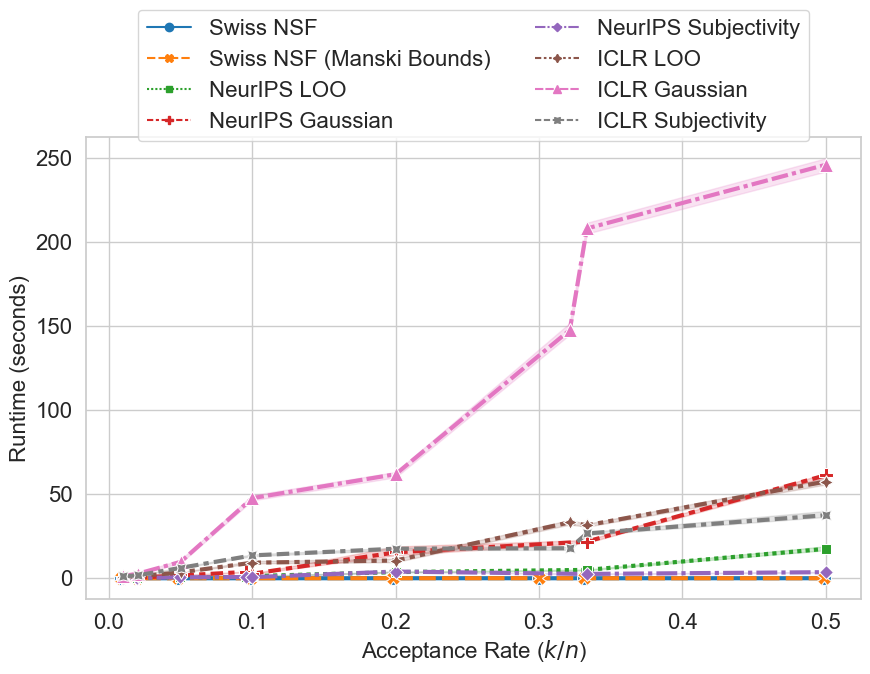

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=results_df,
    x='acceptance_rate',
    y='timing_total_time',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    lw=3,
    markersize=10,
    hue_order=DATASETS,
    palette=sns.color_palette("tab10"),
    legend="full",
    errorbar=('ci', 100)  # Show 99% confidence intervals
)

# Update legend labels using DATASET_NAMES
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = [DATASET_NAMES[label] if label in DATASET_NAMES else label for label in labels]
plt.legend(handles, updated_labels, fontsize=16, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.3))

plt.xlabel('Acceptance Rate ($k/n$)', fontsize=16)
plt.ylabel('Runtime (seconds)', fontsize=16)

# Make xtick labls and yticks larger
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.savefig('figs/runtime_vs_acceptance_rate.png', bbox_inches='tight')
plt.show()

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_75262/2070562530.py:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(


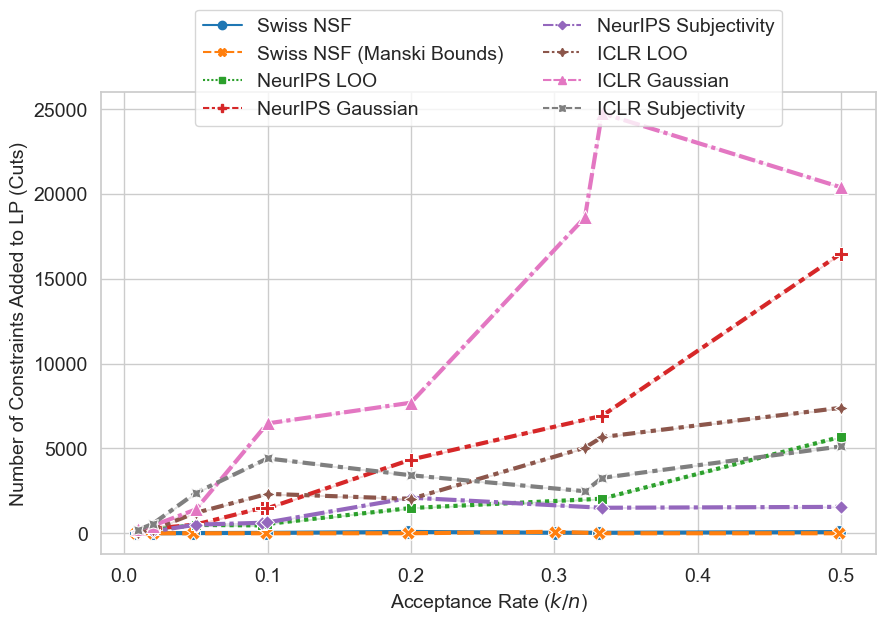

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=results_df,
    x='acceptance_rate',
    y='total_cuts',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    lw=3,
    markersize=10,
    hue_order=DATASETS,
    palette=sns.color_palette("tab10"),
    legend="full"
)

# Update legend labels using DATASET_NAMES
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = [DATASET_NAMES[label] if label in DATASET_NAMES else label for label in labels]
plt.legend(handles, updated_labels, fontsize=14, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.2))

plt.xlabel('Acceptance Rate ($k/n$)', fontsize=14)
plt.ylabel('Number of Constraints Added to LP (Cuts)', fontsize=14)

# Make xtick labels and yticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figs/cuts_vs_acceptance_rate.png', bbox_inches='tight')
plt.show()


/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/4125591643.py:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(


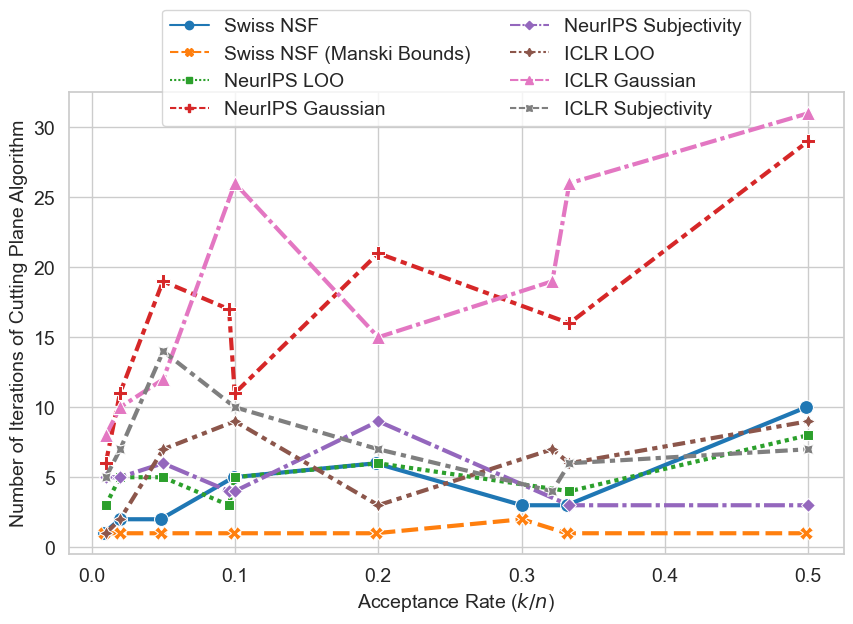

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=results_df,
    x='acceptance_rate',
    y='iterations',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    lw=3,
    markersize=10,
    hue_order=DATASETS,
    palette=sns.color_palette("tab10"),
    legend="full"
)

# Update legend labels using DATASET_NAMES
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = [DATASET_NAMES[label] if label in DATASET_NAMES else label for label in labels]
plt.legend(handles, updated_labels, fontsize=14, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.2))
# plt.legend([], [], frameon=False)

plt.xlabel('Acceptance Rate ($k/n$)', fontsize=14)
plt.ylabel('Number of Iterations of Cutting Plane Algorithm', fontsize=14)

# Make xtick labls and yticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.savefig('figs/iters_vs_acceptance_rate.png', bbox_inches='tight')
plt.show()

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/1698722347.py:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(
/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/1698722347.py:25: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(


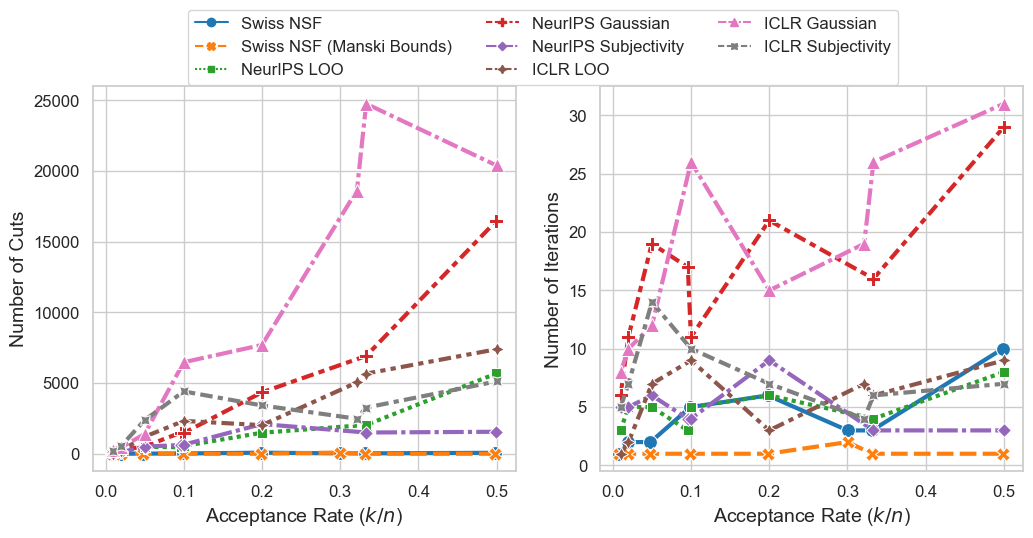

In [19]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5), sharey=False)

# Plot 1: Number of Cuts vs Acceptance Rate
sns.lineplot(
    ax=axes[0],
    data=results_df,
    x='acceptance_rate',
    y='total_cuts',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    lw=3,
    markersize=10,
    hue_order=DATASETS,
    palette=sns.color_palette("tab10"),
    legend=True  # Disable legend for this subplot
)
axes[0].set_xlabel('Acceptance Rate ($k/n$)', fontsize=14)
axes[0].set_ylabel('Number of Cuts', fontsize=14)
axes[0].legend([], [], frameon=False)
axes[0].tick_params(axis='both', labelsize=12)

# Plot 2: Number of Iterations vs Acceptance Rate
sns.lineplot(
    ax=axes[1],
    data=results_df,
    x='acceptance_rate',
    y='iterations',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    lw=3,
    markersize=10,
    hue_order=DATASETS,
    palette=sns.color_palette("tab10"),
    legend=False  # Disable legend for this subplot
)
axes[1].set_xlabel('Acceptance Rate ($k/n$)', fontsize=14)
axes[1].set_ylabel('Number of Iterations', fontsize=14)
axes[1].tick_params(axis='both', labelsize=12)

# Add a figure legend in the top center
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(
    handles, 
    [DATASET_NAMES[label] if label in DATASET_NAMES else label for label in labels], 
    loc='upper center', 
    bbox_to_anchor=(0.5, 1.05), 
    ncol=3, 
    fontsize=12
)

# Adjust layout
plt.savefig('figs/cuts_iters_vs_acceptance_rate.png', bbox_inches='tight')

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/2908153585.py:4: UserWarning: The palette list has more values (10) than needed (8), which may not be intended.
  sns.lineplot(


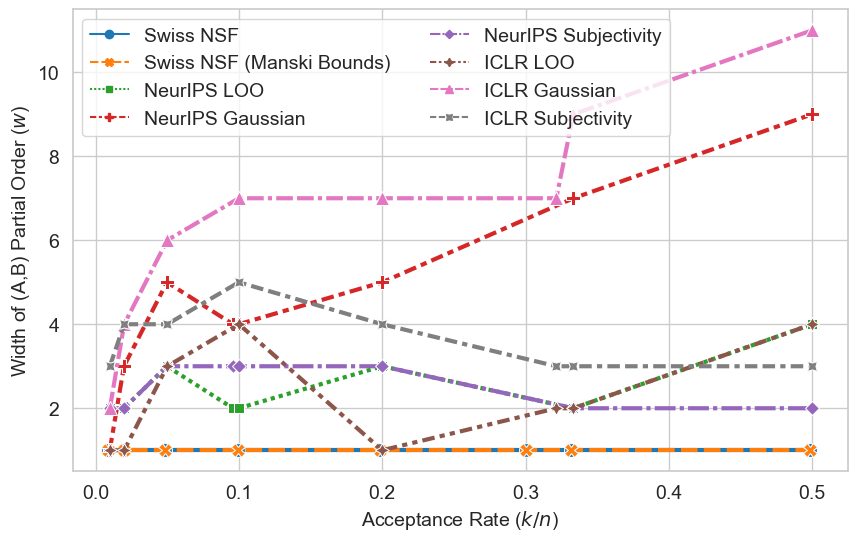

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

sns.lineplot(
    data=results_df,
    x='acceptance_rate',
    y='n_chains',
    hue='dataset',
    style='dataset',
    markers=True,
    dashes=True,
    lw=3,
    markersize=10,
    hue_order=DATASETS,
    palette=sns.color_palette("tab10"),
    legend="full"
)

# Update legend labels using DATASET_NAMES
handles, labels = plt.gca().get_legend_handles_labels()
updated_labels = [DATASET_NAMES[label] if label in DATASET_NAMES else label for label in labels]
plt.legend(handles, updated_labels, fontsize=14, ncol=2)

plt.xlabel('Acceptance Rate ($k/n$)', fontsize=14)
plt.ylabel('Width of (A,B) Partial Order ($w$)', fontsize=14)

# Make xtick labls and yticks larger
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.show()

### Ablations 

In [21]:
# read in neurips and iclr ablations results
with open("res/neurips_ablations_results.json") as f:
    data = json.load(f)

df_init = pd.DataFrame(data)

df_neurips = pd.DataFrame()
for split in ['info_all', 'info_none', 'info_pruneonly', 'info_noprune']:
    df_split = df_init[['k', split]].dropna()
    # turn the dict of df_split[split] into columns
    df_cols = pd.json_normalize(df_split[split])
    df_cols['k'] = df_split['k']
    df_cols['optimization'] = split.split('_')[1]
    df_neurips = pd.concat([df_neurips, df_cols], axis=0)

# read in neurips and iclr ablations results
with open("res/iclr_ablations_results.json") as f:
    data = json.load(f)

df_init = pd.DataFrame(data)

df_iclr = pd.DataFrame()
for split in ['info_all', 'info_none', 'info_pruneonly', 'info_noprune']:
    df_split = df_init[['k', split]].dropna()
    # turn the dict of df_split[split] into columns
    df_cols = pd.json_normalize(df_split[split])
    df_cols['k'] = df_split['k']
    df_cols['optimization'] = split.split('_')[1]
    df_iclr = pd.concat([df_iclr, df_cols], axis=0)

df_iclr['dataset'] = 'ICLR'
df_iclr['n'] = n['iclrgaussian']
df_neurips['dataset'] = 'NeurIPS'
df_neurips['n'] = n['neuripsgaussian']
df = pd.concat([df_iclr, df_neurips], axis=0)
df['acceptance_rate'] = 1. * df['k'] / df['n']

df['minutes'] = df['timing.total_time'] / 60

In [22]:
df.head()

,iterations,convergence,total_cuts,n_vars,n_chains,n_mono_constraints,timing.symmetry_setup,timing.monotonicity_constraints_setup,timing.optimization_loop_time,timing.total_time,timing.init_prune_time,k,optimization,dataset,n,acceptance_rate,minutes
0,2,True,37,3,1,2,0.000226,0.000247,0.001127,0.483462,0.460293,37,all,ICLR,11520,0.003212,0.008058
1,4,True,192,9,2,7,0.000555,0.000757,0.004215,0.533955,0.481125,74,all,ICLR,11520,0.006424,0.008899
2,15,True,341,60,4,56,0.005434,0.006885,0.085521,2.013722,0.397276,185,all,ICLR,11520,0.016059,0.033562
3,15,True,862,78,6,72,0.006015,0.008252,0.323513,5.827234,0.399605,370,all,ICLR,11520,0.032118,0.097121
4,12,True,2415,79,6,73,0.009734,0.008049,0.733764,11.148692,0.453155,740,all,ICLR,11520,0.064236,0.185812


In [23]:
df['optimization'] = df['optimization'].replace({
    'all': 'All',
    'none': 'None',
    'pruneonly': 'Only Pruning',
    'noprune': 'Only Symmetry + Monotonicity'
})

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/11148800.py:5: UserWarning: The markers list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(


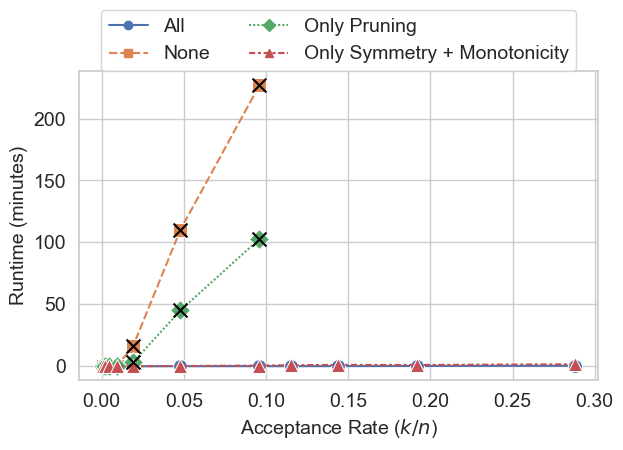

In [24]:
# Filter data for NeurIPS
neurips_data = df[df['dataset'] == 'NeurIPS']

# Plot NeurIPS data without using 'x' as a marker
sns.lineplot(
    data=neurips_data,
    x='acceptance_rate',
    y='minutes',
    hue='optimization',
    style='optimization',
    dashes=True,
    markers=["o", "s", "D", "^", "v", "<", ">"],  # Specify markers explicitly, avoiding 'x'
    markersize=10
)

# for points where df['convergence'] == False, use 'x' as a marker in black instead
non_converged = neurips_data[neurips_data['convergence'] == False]
plt.scatter(
    non_converged['acceptance_rate'],
    non_converged['minutes'],
    color='black',
    marker='x',
    s=100,  # size of the marker
    zorder=10  # Ensures 'x' markers are drawn on top of other markers
)

plt.xlabel('Acceptance Rate ($k/n$)', fontsize=14)
plt.ylabel('Runtime (minutes)', fontsize=14)
plt.legend(fontsize=14, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.23))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig('figs/neurips_ablations_runtime.png', bbox_inches='tight')
plt.show()

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/331925811.py:5: UserWarning: The markers list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(


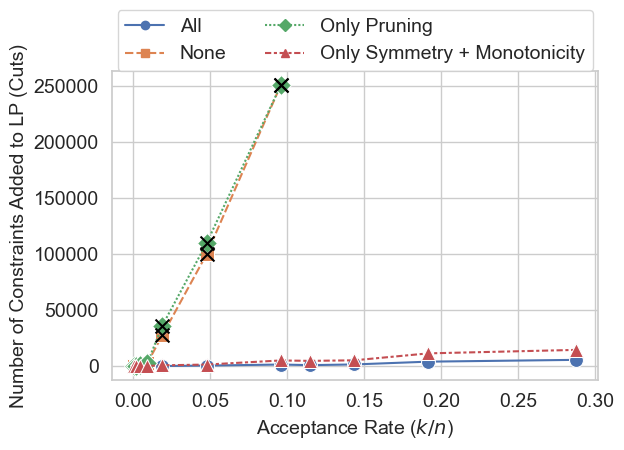

In [25]:
# Filter data for NeurIPS
neurips_data = df[df['dataset'] == 'NeurIPS']

# Plot NeurIPS data without using 'x' as a marker
sns.lineplot(
    data=neurips_data,
    x='acceptance_rate',
    y='total_cuts',
    hue='optimization',
    style='optimization',
    dashes=True,
    markers=["o", "s", "D", "^", "v", "<", ">"],  # Specify markers explicitly, avoiding 'x'
    markersize=10
)

# for points where df['convergence'] == False, use 'x' as a marker in black instead
non_converged = neurips_data[neurips_data['convergence'] == False]
plt.scatter(
    non_converged['acceptance_rate'],
    non_converged['total_cuts'],
    color='black',
    marker='x',
    s=100,  # size of the marker
    zorder=10  # Ensures 'x' markers are drawn on top of other markers
)

plt.xlabel('Acceptance Rate ($k/n$)', fontsize=14)
plt.ylabel('Number of Constraints Added to LP (Cuts)', fontsize=14)
plt.legend(fontsize=14, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.23))

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.tight_layout()
# plt.savefig('figs/neurips_ablations_cuts.png', bbox_inches='tight')
plt.show()

/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/1005410574.py:5: UserWarning: The markers list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(
/var/folders/bf/h8803kcx3fq5w8st_rt9637m0000gr/T/ipykernel_47868/1005410574.py:30: UserWarning: The markers list has more values (7) than needed (4), which may not be intended.
  sns.lineplot(


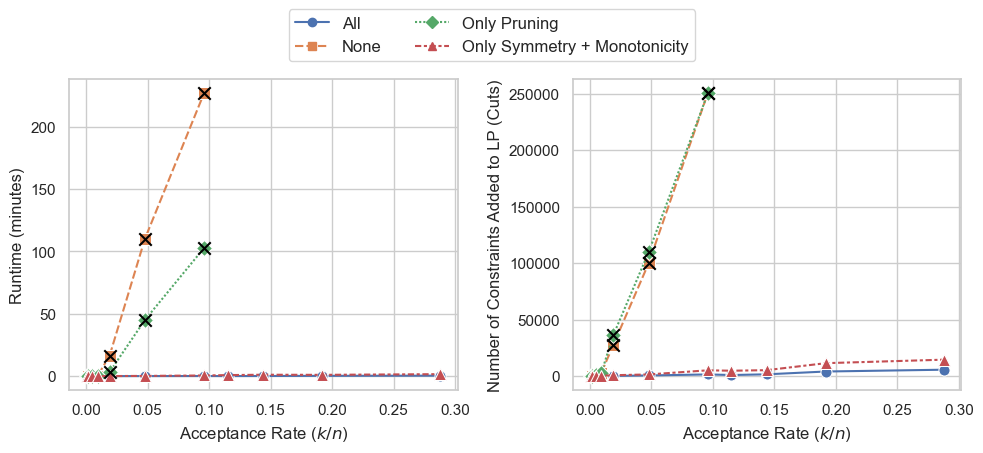

In [26]:
sns.set(style="whitegrid")
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=False)

# Plot 1: Runtime vs Acceptance Rate
sns.lineplot(
    ax=axes[0],
    data=neurips_data,
    x='acceptance_rate',
    y='minutes',
    hue='optimization',
    style='optimization',
    dashes=True,
    markers=["o", "s", "D", "^", "v", "<", ">"],
    markersize=8
)
non_converged_runtime = neurips_data[neurips_data['convergence'] == False]
axes[0].scatter(
    non_converged_runtime['acceptance_rate'],
    non_converged_runtime['minutes'],
    color='black',
    marker='x',
    s=80,
    zorder=10
)
axes[0].set_xlabel('Acceptance Rate ($k/n$)', fontsize=12)
axes[0].set_ylabel('Runtime (minutes)', fontsize=12)
axes[0].legend([], [], frameon=False)

# Plot 2: Number of Constraints vs Acceptance Rate
sns.lineplot(
    ax=axes[1],
    data=neurips_data,
    x='acceptance_rate',
    y='total_cuts',
    hue='optimization',
    style='optimization',
    dashes=True,
    markers=["o", "s", "D", "^", "v", "<", ">"],
    markersize=8,
    legend=False  # Disable legend for the right subplot
)
non_converged_cuts = neurips_data[neurips_data['convergence'] == False]
axes[1].scatter(
    non_converged_cuts['acceptance_rate'],
    non_converged_cuts['total_cuts'],
    color='black',
    marker='x',
    s=80,
    zorder=10
)
axes[1].set_xlabel('Acceptance Rate ($k/n$)', fontsize=12)
axes[1].set_ylabel('Number of Constraints Added to LP (Cuts)', fontsize=12)

# Shared legend
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, fontsize=12, ncol=2, loc='upper center', bbox_to_anchor=(0.5, 1.15))

# Adjust layout
plt.tight_layout()
plt.savefig('figs/neurips_ablation_combined_horizontal_plots.png', bbox_inches='tight')
plt.show()

## Comparison of Outcomes

### Swiss NSF

In [27]:
# load Swiss NSF data
with open(f'res/swiss_nsf_results.pkl', 'rb') as file:
    res = pickle.load(file)

In [28]:
p_merit = np.round(res['p_opt'], 3)
v_merit = res['v_opt']
p_swiss = np.round(res['p_swiss'][-1], 3)
p_topk = res['top_k']

k = loaded_data['swiss_nsf']['k']
v_swiss = evaluate_p(loaded_data['swiss_nsf']['intervals'], p_swiss, k)
v_topk = evaluate_p(loaded_data['swiss_nsf']['intervals'], p_topk, k)

In [29]:
# get value counts of p_merit
pd.Series(p_merit).value_counts().sort_index()

0.0    241
0.5     12
1.0    100
Name: count, dtype: int64

In [30]:
pd.Series(p_swiss).value_counts().sort_index()

0.000    241
0.538     13
1.000     99
Name: count, dtype: int64

### NeurIPS Subjectivity Intervals

In [31]:
# load Swiss NSF data
with open(f'res/neuripssubjectivity_results.pkl', 'rb') as file:
    res = pickle.load(file)

In [32]:
def analyze_case_study(dataset):
    with open(f'res/{dataset}_results.pkl', 'rb') as file:
        res = pickle.load(file)

    p_merit = np.round(res['p_opt'], 3)
    v_merit = res['v_opt']
    p_swiss = np.round(res['p_swiss'][-1], 3)
    p_topk = res['top_k']

    k = loaded_data[dataset]['k']
    v_swiss = evaluate_p(loaded_data[dataset]['intervals'], p_swiss, k)
    v_topk = evaluate_p(loaded_data[dataset]['intervals'], p_topk, k)

    # Return (Number Accepted, Number Randomized, Number Rejected, Range of probabiliites, Objective Value) for each method
    num_accepted_merit = sum(p_merit == 1)
    num_rejected_merit = sum(p_merit == 0)
    num_randomized_merit = len(p_merit) - num_accepted_merit - num_rejected_merit
    range_merit = (np.min(p_merit[p_merit > 0]), np.max(p_merit[p_merit < 1]))
    top_k_expected_merit = p_merit[p_topk == 1].sum() / k

    num_accepted_swiss = sum(p_swiss == 1)
    num_rejected_swiss = sum(p_swiss == 0)
    num_randomized_swiss = len(p_swiss) - num_accepted_swiss - num_rejected_swiss
    range_swiss = np.min(p_swiss[p_swiss > 0])
    top_k_expected_swiss = p_swiss[p_topk == 1].sum() / k
    
    return (
        num_accepted_merit / n[dataset], num_randomized_merit / n[dataset], range_merit, v_merit / k, top_k_expected_merit,
        num_accepted_swiss / n[dataset], num_randomized_swiss / n[dataset], range_swiss, v_swiss / k, top_k_expected_swiss,
        v_topk / k
    )

In [33]:
# run on all datasets and put in dataframe
results = []
for dataset in DATASETS:
    print(f'Analyzing {dataset}')
    result = analyze_case_study(dataset)
    results.append((dataset,) + result)
columns = [
    'dataset', 'num_accepted_merit', 'num_randomized_merit', 'range_merit', 'v_merit', 'top_k_expected_merit',
    'num_accepted_swiss', 'num_randomized_swiss', 'range_swiss', 'v_swiss', 'top_k_expected_swiss', 'v_topk'
]
df = pd.DataFrame(results, columns=columns)
df['target_acceptance_rate'] = df['dataset'].map(lambda d: actual_k[d] / n[d])
df['dataset'] = df['dataset'].map(DATASET_NAMES)

Analyzing swiss_nsf
Analyzing swiss_nsf_manski
Analyzing neuripsloo
Analyzing neuripsgaussian
Analyzing neuripssubjectivity
Analyzing iclrloo
Analyzing iclrgaussian
Analyzing iclrsubjectivity


In [34]:
df_prob = df[['dataset',
              'num_accepted_merit', 'num_randomized_merit', 'range_merit',
               'num_accepted_swiss', 'num_randomized_swiss', 'range_swiss']]

In [35]:
df_prob

,dataset,num_accepted_merit,num_randomized_merit,range_merit,num_accepted_swiss,num_randomized_swiss,range_swiss
0,Swiss NSF,0.283286,0.033994,"(0.5, 0.5)",0.280453,0.036827,0.538
1,Swiss NSF (Manski Bounds),0.053824,0.269122,"(0.748, 0.935)",0.053824,0.269122,0.916
2,NeurIPS LOO,0.034201,0.164808,"(0.361, 0.936)",0.034201,0.179430,0.344
3,NeurIPS Gaussian,0.022305,0.257497,"(0.16, 0.83)",0.039901,0.275093,0.204
4,NeurIPS Subjectivity,0.044610,0.187113,"(0.14, 0.451)",0.015613,0.103594,0.775
5,ICLR LOO,0.111458,0.323524,"(0.514, 0.876)",0.220312,0.227604,0.444
6,ICLR Gaussian,0.094618,0.343924,"(0.453, 0.868)",0.211806,0.276997,0.396
7,ICLR Subjectivity,0.175521,0.242535,"(0.494, 0.878)",0.162240,0.252257,0.631


In [36]:
# print out df_prob as latex table rounded to 3 decimal places
print(df_prob.to_latex(index=False, float_format=lambda x: f"{x*100:.1f}" if isinstance(x, float) else x, escape=False, column_format='lcccccccccc', 
                        label='tab:probability_results', caption='Probability Results for All Datasets'))

\begin{table}
\caption{Probability Results for All Datasets}
\label{tab:probability_results}
\begin{tabular}{lcccccccccc}
\toprule
dataset & num_accepted_merit & num_randomized_merit & range_merit & num_accepted_swiss & num_randomized_swiss & range_swiss \\
\midrule
Swiss NSF & 28.3 & 3.4 & (0.5, 0.5) & 28.0 & 3.7 & 53.8 \\
Swiss NSF (Manski Bounds) & 5.4 & 26.9 & (0.748, 0.935) & 5.4 & 26.9 & 91.6 \\
NeurIPS LOO & 3.4 & 16.5 & (0.361, 0.936) & 3.4 & 17.9 & 34.4 \\
NeurIPS Gaussian & 2.2 & 25.7 & (0.16, 0.83) & 4.0 & 27.5 & 20.4 \\
NeurIPS Subjectivity & 4.5 & 18.7 & (0.14, 0.451) & 1.6 & 10.4 & 77.5 \\
ICLR LOO & 11.1 & 32.4 & (0.514, 0.876) & 22.0 & 22.8 & 44.4 \\
ICLR Gaussian & 9.5 & 34.4 & (0.453, 0.868) & 21.2 & 27.7 & 39.6 \\
ICLR Subjectivity & 17.6 & 24.3 & (0.494, 0.878) & 16.2 & 25.2 & 63.1 \\
\bottomrule
\end{tabular}
\end{table}



In [37]:
df_objvalue = df[['dataset', 'v_merit', 'v_swiss', 'v_topk']]
print(df_objvalue.to_latex(index=False, float_format=lambda x: f"{x:.3f}" if isinstance(x, float) else x, escape=False, column_format='lcccccc',
                        label='tab:objective_value_results', caption='Objective Value Results for All Datasets'))

\begin{table}
\caption{Objective Value Results for All Datasets}
\label{tab:objective_value_results}
\begin{tabular}{lcccccc}
\toprule
dataset & v_merit & v_swiss & v_topk \\
\midrule
Swiss NSF & 0.943 & 0.939 & 0.934 \\
Swiss NSF (Manski Bounds) & 0.929 & 0.914 & 0.925 \\
NeurIPS LOO & 0.395 & 0.371 & 0.054 \\
NeurIPS Gaussian & 0.367 & 0.231 & 0.199 \\
NeurIPS Subjectivity & 0.540 & 0.347 & 0.377 \\
ICLR LOO & 0.690 & 0.637 & 0.647 \\
ICLR Gaussian & 0.684 & 0.574 & 0.579 \\
ICLR Subjectivity & 0.749 & 0.680 & 0.650 \\
\bottomrule
\end{tabular}
\end{table}



## Check Monotonicity of Swiss NSF

In [33]:
from helpers import swiss_nsf, verify_monotonicity_in_k

In [29]:
x = loaded_data['swiss_nsf']['x']
intervals = loaded_data['swiss_nsf']['intervals']
k = loaded_data['swiss_nsf']['k']

In [31]:
p_swiss_seq = [swiss_nsf(intervals, x, i) for i in range(k)]

In [36]:
# check point wise monotonicity of p_swiss_seq
helpers.verify_monotonicity_in_k(p_swiss_seq)

p is not monotonic for k=1 p(0)=0.167 and (k-1)=0, p(0)=1.
p is not monotonic for k=1 p(1)=0.167 and (k-1)=0, p(1)=1.
p is not monotonic for k=1 p(2)=0.167 and (k-1)=0, p(2)=1.
p is not monotonic for k=1 p(3)=0.167 and (k-1)=0, p(3)=1.
p is not monotonic for k=1 p(4)=0.167 and (k-1)=0, p(4)=1.
p is not monotonic for k=1 p(5)=0.167 and (k-1)=0, p(5)=1.
p is not monotonic for k=1 p(6)=0 and (k-1)=0, p(6)=1.
p is not monotonic for k=1 p(7)=0 and (k-1)=0, p(7)=1.
p is not monotonic for k=1 p(8)=0 and (k-1)=0, p(8)=1.
p is not monotonic for k=1 p(9)=0 and (k-1)=0, p(9)=1.
p is not monotonic for k=1 p(10)=0 and (k-1)=0, p(10)=1.
p is not monotonic for k=1 p(11)=0 and (k-1)=0, p(11)=1.
p is not monotonic for k=1 p(12)=0 and (k-1)=0, p(12)=1.
p is not monotonic for k=1 p(13)=0 and (k-1)=0, p(13)=1.
p is not monotonic for k=1 p(14)=0 and (k-1)=0, p(14)=1.
p is not monotonic for k=1 p(15)=0 and (k-1)=0, p(15)=1.
p is not monotonic for k=1 p(16)=0 and (k-1)=0, p(16)=1.
p is not monotonic for k=1 

True

## Swiss NSF Manski Bounds w/ Added Sparsity

In [ ]:
from helpers import swiss_nsf, top_k
from merit import solve_problem

In [47]:
df_manski = pd.read_csv('SwissNSFData/manski_bounds_sparse.csv')
k = actual_k['swiss_nsf_manski']

In [55]:
res = {}
for density in df_manski['density'].unique():
    for iter in df_manski['iter'].unique():
        df_subset = df_manski[(df_manski['density'] == density) & (df_manski['iter'] == iter)]
        x = df_subset['x'].values
        lower = df_subset['lower'].values
        upper = df_subset['upper'].values
        intervals = list(zip(lower, upper))
        p_merit,_,_ = solve_problem(intervals, k)
        p_swiss = swiss_nsf(intervals, x, k)
        p_topk = top_k(x, k)
        v_merit = evaluate_p(intervals, p_merit, k) / k
        v_swiss = evaluate_p(intervals, p_swiss, k) / k
        v_topk = evaluate_p(intervals, p_topk, k) / k
        res[density, iter] = {
            'MERIT': v_merit,
            'Swiss NSF': v_swiss,
            'Deterministic top-$k$': v_topk
        }

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [56]:
res_df = pd.DataFrame.from_dict(res, orient='index')

In [58]:
res_df = res_df.reset_index().rename(columns={'level_0': 'density', 'level_1': 'iter'})

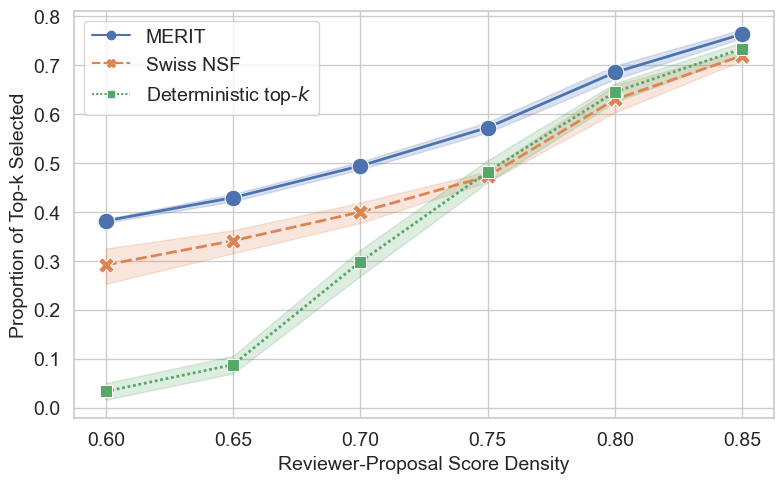

In [ ]:
# Melt res_df to long format for plotting
plot_df = res_df.melt(id_vars=['density', 'iter'], 
                      value_vars=['MERIT', 'Swiss NSF', 'Deterministic top-$k$'],
                      var_name='Method', value_name='Proportion')

sns.set(style="whitegrid")
plt.figure(figsize=(8, 5))

# Plot with error bars (mean ± std) using seaborn's lineplot with errorbar
sns.lineplot(
    data=plot_df,
    x='density',
    y='Proportion',
    hue='Method',
    style='Method',
    markers=True,
    dashes=True,
    lw=2,
    markersize=12,
    errorbar=('ci', 95)  # 1 stddev error bars
)

plt.xlabel('Reviewer-Proposal Score Density', fontsize=14)
plt.ylabel('Proportion of Top-k Selected', fontsize=14)
plt.legend(fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.tight_layout()
plt.savefig('figs/swiss_nsf_manski_bounds_density_results.png', bbox_inches='tight')

# Flip the x-axis 
# 